# 1. Low-Rank Decomposition (LRD) for Matrix Factorization

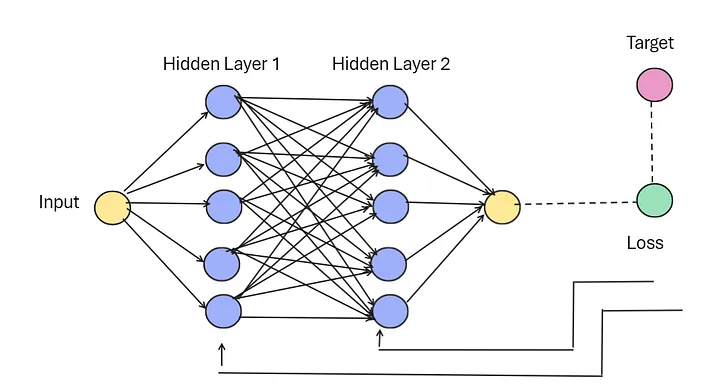
</br>
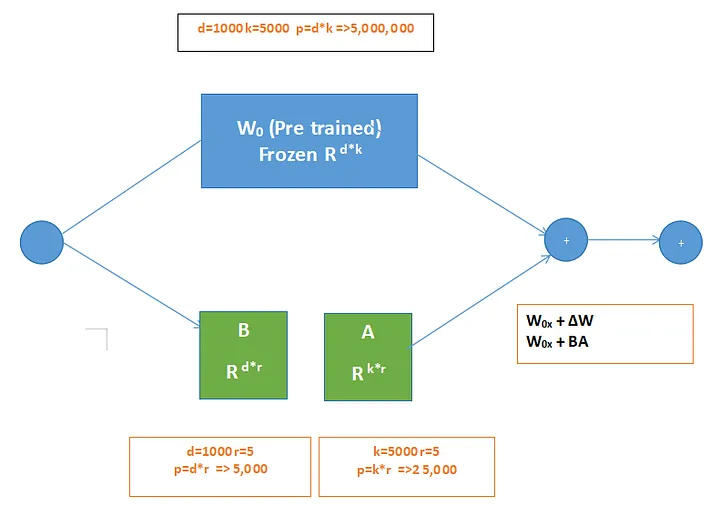

https://medium.com/@sathishparamasivam/lora-low-rank-adaptation-of-large-language-models-mathematical-approach-svd-b6a41ef52bc5

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified
Showing images for class: plane


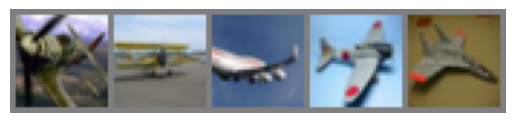

Showing images for class: car


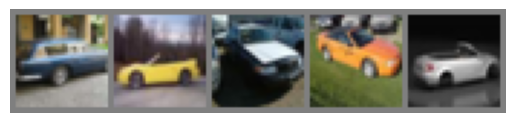

Showing images for class: bird


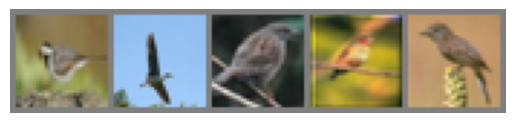

Showing images for class: cat


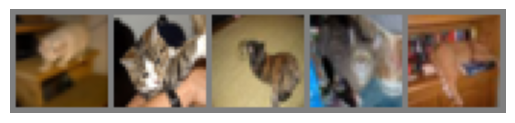

Showing images for class: deer


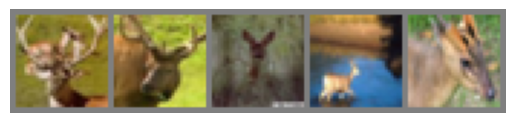

Showing images for class: dog


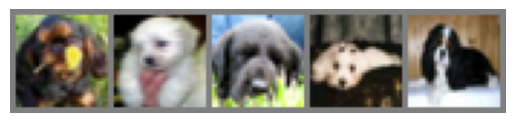

Showing images for class: frog


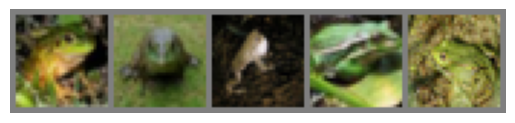

Showing images for class: horse


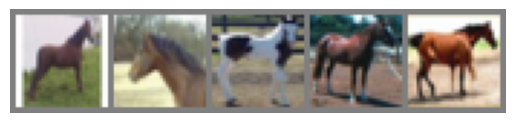

Showing images for class: ship


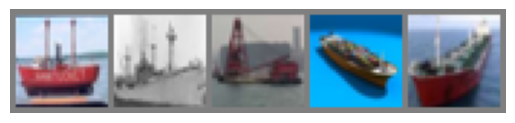

Showing images for class: truck


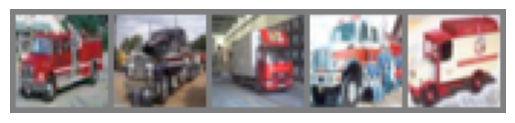

In [24]:
# -----------------------------
# 1. Data Loading and Preprocessing
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='/media/data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='/media/data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# -----------------------------
# 2. Visualizing Data
# -----------------------------
def imshow(img):
    img = img / 2 + 0.5  # 역정규화
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
def show_class_images(class_name, num_images=5):
    class_idx = classes.index(class_name)
    images = []
    for data in trainloader:
        inputs, labels = data
        for i in range(len(labels)):
            if labels[i] == class_idx and len(images) < num_images:
                images.append(inputs[i])
            if len(images) >= num_images:
                break
        if len(images) >= num_images:
            break
    if images:
        imshow(torchvision.utils.make_grid(images, nrow=num_images))
    else:
        print(f"No images found for class: {class_name}")
# 클래스별 이미지 출력
for class_name in classes:
    print(f"Showing images for class: {class_name}")
    show_class_images(class_name, num_images=5)
# -----------------------------

In [25]:
# -----------------------------
# 3. Baseline CNN Model
# -----------------------------
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # d=4096, k=512
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
# 모델 초기화
baseline_model = BaselineCNN().to(device)

In [26]:
def train_model(model, trainloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.3f}')

def evaluate_model(model, testloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [27]:
# -----------------------------
# 4. Training and Evaluating Baseline Model
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

print("Training Baseline Model...")
train_model(baseline_model, trainloader, epochs=5)
baseline_acc = evaluate_model(baseline_model, testloader)
print(f'Baseline Model Test Accuracy: {baseline_acc:.2f}%')

# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

baseline_params = count_parameters(baseline_model)
print(f'Baseline Model Parameters: {baseline_params}')

Training Baseline Model...
Epoch 1, Loss: 1.329
Epoch 2, Loss: 0.955
Epoch 3, Loss: 0.785
Epoch 4, Loss: 0.644
Epoch 5, Loss: 0.504
Baseline Model Test Accuracy: 73.30%
Baseline Model Parameters: 2122186


In [ ]:
# -----------------------------
# 5. Low-Rank CNN Model via SVD
# -----------------------------
class LowRankCNN(nn.Module):
    def __init__(self, baseline_model, r=None):
        super(LowRankCNN, self).__init__()
        self.conv1 = baseline_model.conv1
        self.conv2 = baseline_model.conv2
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # SVD: d x k -> (d x r) * (r x k)
        weight = baseline_model.fc1.weight.data  # Shape: [k=512, d=4096]
        U, S, V = torch.svd_lowrank(weight, q=r)  # SVD decomposition
        self.r = r
        U_r = U[:, :r]  # [k=512, r]
        S_r = S[:r]  # [r]
        V_r = V[:, :r]  # [d=4096, r]

        self.fc1_1 = nn.Linear(64 * 8 * 8, r, bias=False)  # V_r^T: [r, d=4096]
        self.fc1_1.weight.data = V_r.t()
        self.fc1_2 = nn.Linear(r, 512, bias=True)  # U_r * diag(S_r): [k=512, r]
        self.fc1_2.weight.data = U_r @ torch.diag(S_r)
        self.fc1_2.bias.data = baseline_model.fc1.bias.data

        self.fc2 = baseline_model.fc2

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1_1(x))
        x = self.fc1_2(x)
        x = self.fc2(x)
        return x

# i want to train the low-rank model with different ranks
ranks = [2, 4, 8, 32, 128]
results = []

for r in ranks:
    print(f"\nTraining Low-Rank Model with r={r}...")
    low_rank_model = LowRankCNN(baseline_model, r=r).to(device)
    optimizer = optim.Adam(low_rank_model.parameters(), lr=0.0001)
    train_model(low_rank_model, trainloader, epochs=5)  # Fine-tuning
    low_rank_acc = evaluate_model(low_rank_model, testloader)
    low_rank_params = count_parameters(low_rank_model)
    param_reduction = (1 - low_rank_params / baseline_params) * 100

    print(f'Low-Rank Model (r={r}) Test Accuracy: {low_rank_acc:.2f}%')
    print(f'Low-Rank Model (r={r}) Parameters: {low_rank_params}')
    print(f'Parameter Reduction: {param_reduction:.2f}%')

    results.append({
        'r': r,
        'accuracy': low_rank_acc,
        'parameters': low_rank_params,
        'param_reduction': param_reduction
    })


Training Low-Rank Model with r=2...
Epoch 1, Loss: 2.022
Epoch 2, Loss: 1.693
Epoch 3, Loss: 1.570
Epoch 4, Loss: 1.497
Epoch 5, Loss: 1.437
Low-Rank Model (r=2) Test Accuracy: 40.76%
Low-Rank Model (r=2) Parameters: 34250
Parameter Reduction: 98.39%

Training Low-Rank Model with r=4...
Epoch 1, Loss: 2.247
Epoch 2, Loss: 1.417
Epoch 3, Loss: 1.101
Epoch 4, Loss: 1.028
Epoch 5, Loss: 0.982
Low-Rank Model (r=4) Test Accuracy: 60.35%
Low-Rank Model (r=4) Parameters: 43466
Parameter Reduction: 97.95%

Training Low-Rank Model with r=8...
Epoch 1, Loss: 1.290
Epoch 2, Loss: 0.773
Epoch 3, Loss: 0.705
Epoch 4, Loss: 0.669
Epoch 5, Loss: 0.644
Low-Rank Model (r=8) Test Accuracy: 69.66%
Low-Rank Model (r=8) Parameters: 61898
Parameter Reduction: 97.08%

Training Low-Rank Model with r=32...
Epoch 1, Loss: 0.850
Epoch 2, Loss: 0.628
Epoch 3, Loss: 0.570
Epoch 4, Loss: 0.532
Epoch 5, Loss: 0.500
Low-Rank Model (r=32) Test Accuracy: 72.08%
Low-Rank Model (r=32) Parameters: 172490
Parameter Reduct

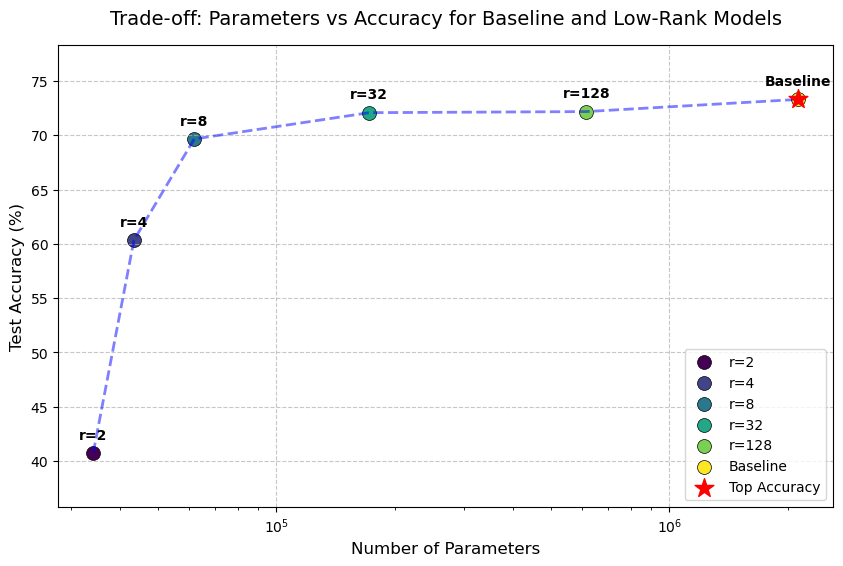

Trade-off visualization saved as 'tradeoff_params_accuracy_sorted.png'


In [28]:
data = [
    {'label': 'Baseline', 'parameters': baseline_params, 'accuracy': baseline_acc}
] + [
    {'label': f'r={r["r"]}', 'parameters': r['parameters'], 'accuracy': r['accuracy']}
    for r in results
]

data_sorted = sorted(data, key=lambda x: x['parameters'])
labels = [d['label'] for d in data_sorted]
params = [d['parameters'] for d in data_sorted]
accs = [d['accuracy'] for d in data_sorted]

# find the maximum accuracy and its corresponding parameters
max_acc_idx = np.argmax(accs)
max_acc_params = params[max_acc_idx]
max_acc = accs[max_acc_idx]

plt.figure(figsize=(10, 6), dpi=100)

colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
for i, (param, acc, label) in enumerate(zip(params, accs, labels)):
    plt.scatter(param, acc, s=100, c=[colors[i]], label=label, edgecolors='black', linewidth=0.5)

# highlight the maximum accuracy point
plt.scatter(max_acc_params, max_acc, s=200, c='red', marker='*', label='Top Accuracy', zorder=10)
plt.plot(params, accs, 'b--', alpha=0.5, linewidth=2)
for i, label in enumerate(labels):
    plt.annotate(label, (params[i], accs[i]), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, fontweight='bold')

plt.xlabel('Number of Parameters', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Trade-off: Parameters vs Accuracy for Baseline and Low-Rank Models', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='lower right')

plt.xscale('log')
plt.ylim(min(accs) - 5, max(accs) + 5)
plt.show()

plt.savefig('tradeoff_params_accuracy_sorted.png', bbox_inches='tight')
plt.close()

print("Trade-off visualization saved as 'tradeoff_params_accuracy_sorted.png'")

# 2. Feature Visualization with t-SNE in Knowledge Distillation

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [30]:
# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='/media/data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='/media/data', train=False, download=True, transform=transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [32]:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map

class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Include an extra regressor (in our case linear)
        self.regressor = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output

In [33]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, hidden1 = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, hidden1 = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [34]:
torch.manual_seed(42)
teacher = DeepNN(num_classes=10).to(device)
train(teacher, train_loader, epochs=10, learning_rate=0.001, device=device)
teacher_acc = test(teacher, test_loader, device)

Epoch 1/10, Loss: 1.3345449815320847
Epoch 2/10, Loss: 0.8622143762495816
Epoch 3/10, Loss: 0.6820173528798096
Epoch 4/10, Loss: 0.5375903884468176
Epoch 5/10, Loss: 0.42626193478284286
Epoch 6/10, Loss: 0.3194791283220281
Epoch 7/10, Loss: 0.23578916084202353
Epoch 8/10, Loss: 0.17278052149983622
Epoch 9/10, Loss: 0.13623680755534134
Epoch 10/10, Loss: 0.12417391206487975
Test Accuracy: 74.42%


In [35]:
# Instantiate the lightweight network:
torch.manual_seed(42)
student_wo_kd = LightNN(num_classes=10).to(device)

torch.manual_seed(42)
student_w_kd = LightNN(num_classes=10).to(device)

In [36]:
total_params_teacher = "{:,}".format(sum(p.numel() for p in teacher.parameters()))
print(f"DeepNN parameters: {total_params_teacher}")
total_params_student = "{:,}".format(sum(p.numel() for p in student_w_kd.parameters()))
print(f"LightNN parameters: {total_params_student}")

DeepNN parameters: 1,186,986
LightNN parameters: 70,098


In [37]:
train(student_wo_kd, train_loader, epochs=10, learning_rate=0.001, device=device)
student_wo_kd_acc = test(student_wo_kd, test_loader, device)

Epoch 1/10, Loss: 1.6147184326215778
Epoch 2/10, Loss: 1.3260432838478966
Epoch 3/10, Loss: 1.2236911335869518
Epoch 4/10, Loss: 1.154079541983202
Epoch 5/10, Loss: 1.1019287072789028
Epoch 6/10, Loss: 1.0532998087461038
Epoch 7/10, Loss: 1.0118245595251507
Epoch 8/10, Loss: 0.9738572492928761
Epoch 9/10, Loss: 0.9418398858336232
Epoch 10/10, Loss: 0.9198338613485741
Test Accuracy: 64.07%


In [38]:
print(f"Teacher accuracy: {teacher_acc:.2f}%")
print(f"Student w/o KD accuracy: {student_wo_kd_acc:.2f}%")

Teacher accuracy: 74.42%
Student w/o KD accuracy: 64.07%


In [39]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Again ignore teacher logits
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)

            # Forward pass with the student model
            student_logits, regressor_feature_map = student(inputs)

            # Calculate the loss
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [40]:
torch.manual_seed(42)
student_w_kd = LightNN(num_classes=10).to(device)

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
teacher_pretrained = DeepNN(num_classes=10).to(device)
teacher_pretrained.load_state_dict(teacher.state_dict())

# Train and test once again
train_mse_loss(teacher=teacher_pretrained, student=student_w_kd, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)
student_w_kd_acc = test(student_w_kd, test_loader, device)
print(f"Student w/ KD accuracy: {student_w_kd_acc:.2f}%")

Epoch 1/10, Loss: 1.853468451353595
Epoch 2/10, Loss: 1.5331804099900033
Epoch 3/10, Loss: 1.4199871666291182
Epoch 4/10, Loss: 1.3354526569166452
Epoch 5/10, Loss: 1.274539508173228
Epoch 6/10, Loss: 1.2291008554151297
Epoch 7/10, Loss: 1.188549051809189
Epoch 8/10, Loss: 1.1588971832829058
Epoch 9/10, Loss: 1.128441681185037
Epoch 10/10, Loss: 1.1089377567896148
Test Accuracy: 65.71%
Student w/ KD accuracy: 65.71%


In [41]:
print(f"Teacher accuracy: {teacher_acc:.2f}%")
print(f"Student w/o KD accuracy: {student_wo_kd_acc:.2f}%")
print(f"Student w/ KD accuracy: {student_w_kd_acc:.2f}%")

Teacher accuracy: 74.42%
Student w/o KD accuracy: 64.07%
Student w/ KD accuracy: 65.71%


In [42]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# get intermediate feature maps
def get_feature_maps(model, inputs):
    model.eval()
    with torch.no_grad():
        _, feature_map = model(inputs.to(device))
    return feature_map.cpu()

# t-SNE
def visualize_tsne(teacher_features, student1_features, student2_features, labels, title_prefix):
    # Flatten features: [batch, 32, 8, 8] -> [batch, 32*8*8]
    teacher_flat = teacher_features.reshape(teacher_features.shape[0], -1)
    student1_flat = student1_features.reshape(student1_features.shape[0], -1)
    student2_flat = student2_features.reshape(student2_features.shape[0], -1)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    teacher_tsne = tsne.fit_transform(teacher_flat)
    student1_tsne = tsne.fit_transform(student1_flat)
    student2_tsne = tsne.fit_transform(student2_flat)
    
    # Plot
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=teacher_tsne[:, 0], y=teacher_tsne[:, 1], hue=labels, palette='tab10', s=20, legend='full')
    plt.title(f"{title_prefix} - t-SNE (Teacher)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=student1_tsne[:, 0], y=student1_tsne[:, 1], hue=labels, palette='tab10', s=20, legend='full')
    plt.title(f"{title_prefix} - t-SNE (Student w/o KD)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=student2_tsne[:, 0], y=student2_tsne[:, 1], hue=labels, palette='tab10', s=20, legend='full')
    plt.title(f"{title_prefix} - t-SNE (Student w/ KD)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    
    plt.tight_layout()
    plt.savefig(f'{title_prefix}_tsne_comparison.png')
    plt.close()

In [43]:
# sample input from data
sample_input, sample_labels = next(iter(testloader))
sample_input, sample_labels = sample_input.to(device), sample_labels.to(device)
print(f"Sample input shape: {sample_input.shape}")

# get feature map from teacher and student models
teacher_feat = get_feature_maps(teacher_pretrained, sample_input) # [1, 32, 8, 8]
student_wo_kd_feat = get_feature_maps(student_wo_kd, sample_input) # [1, 32, 8, 8]
student_w_kd_feat = get_feature_maps(student_w_kd, sample_input) # [1, 32, 8, 8]

Sample input shape: torch.Size([128, 3, 32, 32])


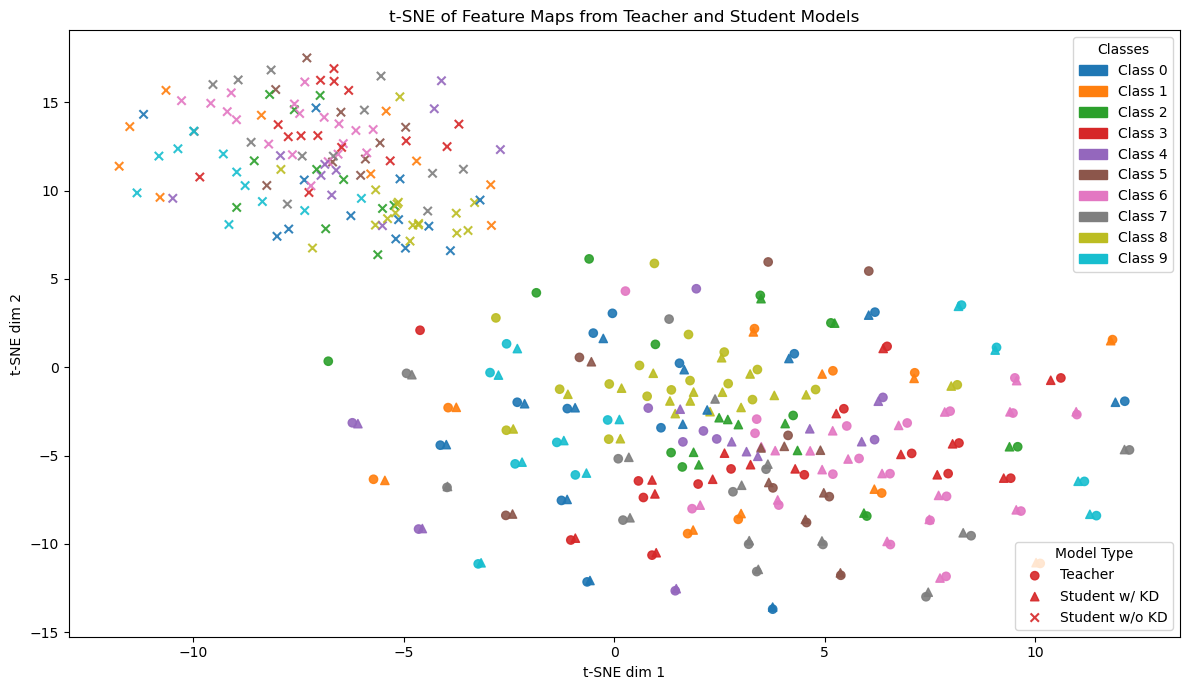

In [44]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def flatten_feature(feat):  # [B, C, H, W] → [B, C*H*W]
    return feat.view(feat.size(0), -1).detach().cpu().numpy()

# extract feature maps
teacher_feat = flatten_feature(get_feature_maps(teacher_pretrained, sample_input))  # [128, D]
student_w_kd_feat = flatten_feature(get_feature_maps(student_w_kd, sample_input))
student_wo_kd_feat = flatten_feature(get_feature_maps(student_wo_kd, sample_input))

# concatenate all features
all_features = np.concatenate([teacher_feat, student_w_kd_feat, student_wo_kd_feat], axis=0)  # [384, D]
labels = sample_labels.cpu().numpy()  # [128]

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_features)

N = sample_input.size(0)
plt.figure(figsize=(12, 7))
scatter_teacher = plt.scatter(tsne_result[:N, 0], tsne_result[:N, 1], c=labels, cmap='tab10', marker='o', label='Teacher', alpha=0.9)
scatter_student_kd = plt.scatter(tsne_result[N:2*N, 0], tsne_result[N:2*N, 1], c=labels, cmap='tab10', marker='^', label='Student w/ KD', alpha=0.9)
scatter_student_wo_kd = plt.scatter(tsne_result[2*N:, 0], tsne_result[2*N:, 1], c=labels, cmap='tab10', marker='x', label='Student w/o KD', alpha=0.9)

# 🎨 Create class legend (class 0~9 for CIFAR-10 etc.)
unique_classes = np.unique(labels)
cmap = plt.get_cmap('tab10')
class_handles = [mpatches.Patch(color=cmap(i), label=f'Class {i}') for i in unique_classes]

legend1 = plt.legend(handles=class_handles, title='Classes', loc='upper right')
plt.gca().add_artist(legend1)
plt.legend(['Teacher', 'Student w/ KD', 'Student w/o KD'], title='Model Type', loc='lower right')

plt.title('t-SNE of Feature Maps from Teacher and Student Models')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.tight_layout()
plt.show()